**Multiplicative Transformer Training (lr=1e-4, 20 Epochs)**

Focused notebook that retrains the strongest attention variant with the requested hyperparameters.

In [1]:
from pathlib import Path
import os
import math
import time
import random
import gc
import re
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from datasets import load_dataset
from numpy.random import default_rng
import matplotlib.pyplot as plt
from nepalitokenizers import WordPiece

d:\AIT\Semester II\NLP\Code\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
SEED = 321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    try:
        torch.zeros(1, device=device).uniform_(-1.0, 1.0)
    except RuntimeError as err:
        print(f'CUDA initialization failed: {err}. Falling back to CPU.')
        device = torch.device('cpu')

print(f'Using device: {device}')

CUDA initialization failed: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
. Falling back to CPU.
Using device: cpu


In [13]:
dataset = load_dataset('opus100', 'en-ne')

rand = default_rng(SEED)
max_samples = 200_000
if len(dataset['train']) > max_samples:
    sampled_idx = set(rand.choice(len(dataset['train']), max_samples, replace=False).tolist())
    dataset['train'] = dataset['train'].filter(lambda _, idx: idx in sampled_idx, with_indices=True)

def extract_language(example, lang):
    return {lang: example['translation'][lang]}

dataset = dataset.map(extract_language, fn_kwargs={'lang': 'ne'})
dataset = dataset.map(extract_language, fn_kwargs={'lang': 'en'}, remove_columns=['translation'])

dataset = dataset.filter(lambda example: not bool(re.search(r'[a-zA-Z]', example['ne'])))

print(dataset)

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 1469
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 153992
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 1527
    })
})


In [14]:
SRC_LANG = 'en'
TGT_LANG = 'ne'

token_transform = {
    SRC_LANG: get_tokenizer('spacy', language='en_core_web_sm'),
    TGT_LANG: WordPiece()
}

def tokenize_data(sample, lang):
    try:
        tokens = token_transform[lang](sample[lang].lower())
    except Exception:
        tokens = token_transform[lang].encode(sample[lang].lower()).tokens
    return {lang: tokens}

tokenized_dataset = dataset.map(tokenize_data, fn_kwargs={'lang': SRC_LANG}, remove_columns=[SRC_LANG])
tokenized_dataset = tokenized_dataset.map(tokenize_data, fn_kwargs={'lang': TGT_LANG}, remove_columns=[TGT_LANG])

Map: 100%|██████████| 1527/1527 [00:00<00:00, 22352.72 examples/s]


In [15]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']
vocab_transform = {}

for ln in [SRC_LANG, TGT_LANG]:
    vocab = build_vocab_from_iterator(
        tokenized_dataset['train'][ln],
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )
    vocab.set_default_index(UNK_IDX)
    vocab_transform[ln] = vocab

print(f"Source vocab size: {len(vocab_transform[SRC_LANG])}")
print(f"Target vocab size: {len(vocab_transform[TGT_LANG])}")

Source vocab size: 12982
Target vocab size: 8240


In [16]:
def sequential_transforms(*transforms):
    def apply_transforms(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except Exception:
                txt_input = transform.encode(txt_input).tokens
        return txt_input
    return apply_transforms

def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANG, TGT_LANG]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln],
        vocab_transform[ln],
        tensor_transform
    )

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        src_sample = sample[SRC_LANG]
        trg_sample = sample[TGT_LANG]
        src_tensor = text_transform[SRC_LANG](src_sample.rstrip('\n'))
        trg_tensor = text_transform[TGT_LANG](trg_sample.rstrip('\n'))
        src_batch.append(src_tensor)
        trg_batch.append(trg_tensor)
        src_len_batch.append(src_tensor.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    src_len_batch = torch.tensor(src_len_batch, dtype=torch.int64)
    return src_batch, src_len_batch, trg_batch

BATCH_SIZE = 64
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(train_loader)
valid_loader_length = len(valid_loader)
test_loader_length = len(test_loader)

print(f'Train batches: {train_loader_length}')
print(f'Validation batches: {valid_loader_length}')
print(f'Test batches: {test_loader_length}')

Train batches: 2407
Validation batches: 24
Test batches: 23


In [20]:
repo_root = Path().resolve()
backend_path = repo_root / 'translation-app' / 'backend'
if str(backend_path) not in sys.path:
    sys.path.append(str(backend_path))

from api.models import Seq2SeqTransformer, Encoder, Decoder

MAX_SEQ_LEN = 512

def initialize_weights(module):
    if hasattr(module, 'weight') and module.weight.dim() > 1:
        nn.init.xavier_uniform_(module.weight.data)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def build_model(input_dim, output_dim, atten_type):
    encoder = Encoder(
        input_dim,
        HID_DIM,
        ENC_LAYERS,
        ENC_HEADS,
        ENC_PF_DIM,
        ENC_DROPOUT,
        atten_type,
        device,
        max_length=MAX_SEQ_LEN
    )
    decoder = Decoder(
        output_dim,
        HID_DIM,
        DEC_LAYERS,
        DEC_HEADS,
        DEC_PF_DIM,
        DEC_DROPOUT,
        atten_type,
        device,
        max_length=MAX_SEQ_LEN
    )
    model = Seq2SeqTransformer(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)
    return model

In [21]:
input_dim = len(vocab_transform[SRC_LANG])
output_dim = len(vocab_transform[TGT_LANG])

HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

LR = 1e-4
EPOCHS = 20
CLIP = 1.0
atten_type = 'multiplicative'

model = build_model(input_dim, output_dim, atten_type)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def train_epoch(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0.0

    for src, src_len, trg in loader:
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        target = trg[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

def evaluate_epoch(model, loader, criterion, loader_length):
    model.eval()
    epoch_loss = 0.0

    with torch.no_grad():
        for src, src_len, trg in loader:
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:, :-1])
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            target = trg[:, 1:].reshape(-1)

            loss = criterion(output, target)
            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [22]:
history = {'train': [], 'valid': []}
best_valid_loss = float('inf')
best_state = None
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, train_loader_length)
    valid_loss = evaluate_epoch(model, valid_loader, criterion, valid_loader_length)

    history['train'].append(train_loss)
    history['valid'].append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_epoch = epoch

    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
    try:
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)
    except OverflowError:
        train_ppl = float('inf')
        valid_ppl = float('inf')

    print(
        f"Epoch {epoch:02d}: {epoch_mins}m {epoch_secs}s | "
        f"Train Loss {train_loss:.3f} (PPL {train_ppl:.1f}) | "
        f"Val Loss {valid_loss:.3f} (PPL {valid_ppl:.1f})"
    )

model.load_state_dict(best_state)
print(f'Loaded best validation checkpoint from epoch {best_epoch}.')

Epoch 01: 11m 55s | Train Loss 3.941 (PPL 51.4) | Val Loss 3.051 (PPL 21.1)
Epoch 02: 11m 57s | Train Loss 2.751 (PPL 15.7) | Val Loss 2.685 (PPL 14.7)
Epoch 03: 11m 58s | Train Loss 2.242 (PPL 9.4) | Val Loss 2.535 (PPL 12.6)
Epoch 04: 12m 41s | Train Loss 1.906 (PPL 6.7) | Val Loss 2.486 (PPL 12.0)
Epoch 05: 12m 44s | Train Loss 1.671 (PPL 5.3) | Val Loss 2.482 (PPL 12.0)
Epoch 06: 12m 39s | Train Loss 1.500 (PPL 4.5) | Val Loss 2.488 (PPL 12.0)
Epoch 07: 11m 27s | Train Loss 1.373 (PPL 3.9) | Val Loss 2.511 (PPL 12.3)
Epoch 08: 11m 33s | Train Loss 1.273 (PPL 3.6) | Val Loss 2.534 (PPL 12.6)
Epoch 09: 11m 25s | Train Loss 1.193 (PPL 3.3) | Val Loss 2.558 (PPL 12.9)
Epoch 10: 11m 16s | Train Loss 1.126 (PPL 3.1) | Val Loss 2.586 (PPL 13.3)
Epoch 11: 11m 26s | Train Loss 1.071 (PPL 2.9) | Val Loss 2.618 (PPL 13.7)
Epoch 12: 11m 16s | Train Loss 1.026 (PPL 2.8) | Val Loss 2.649 (PPL 14.1)
Epoch 13: 11m 13s | Train Loss 0.985 (PPL 2.7) | Val Loss 2.675 (PPL 14.5)
Epoch 14: 11m 13s | Tra

In [23]:
checkpoint_dir = Path('model')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / 'multiplicative_seq2seq_lr1e-4_ep20.pt'
vocab_path = checkpoint_dir / 'vocab_latest.pt'

test_loss = evaluate_epoch(model, test_loader, criterion, test_loader_length)
test_ppl = math.exp(test_loss) if test_loss < 20 else float('inf')

hyperparams = {
    'input_dim': input_dim,
    'output_dim': output_dim,
    'hid_dim': HID_DIM,
    'enc_layers': ENC_LAYERS,
    'dec_layers': DEC_LAYERS,
    'enc_heads': ENC_HEADS,
    'dec_heads': DEC_HEADS,
    'enc_pf_dim': ENC_PF_DIM,
    'dec_pf_dim': DEC_PF_DIM,
    'enc_dropout': ENC_DROPOUT,
    'dec_dropout': DEC_DROPOUT,
    'atten_type': atten_type,
    'src_pad_idx': SRC_PAD_IDX,
    'trg_pad_idx': TRG_PAD_IDX
}

torch.save({'hyperparams': hyperparams, 'state_dict': model.state_dict()}, checkpoint_path)
torch.save(vocab_transform, vocab_path)

print(f'Saved model to {checkpoint_path}')
print(f'Saved vocab to {vocab_path}')
print(f'Best validation loss: {best_valid_loss:.3f} (epoch {best_epoch})')
print(f'Test loss: {test_loss:.3f} | Test perplexity: {test_ppl:.1f}')

Saved model to model\multiplicative_seq2seq_lr1e-4_ep20.pt
Saved vocab to model\vocab_latest.pt
Best validation loss: 2.482 (epoch 5)
Test loss: 2.378 | Test perplexity: 10.8


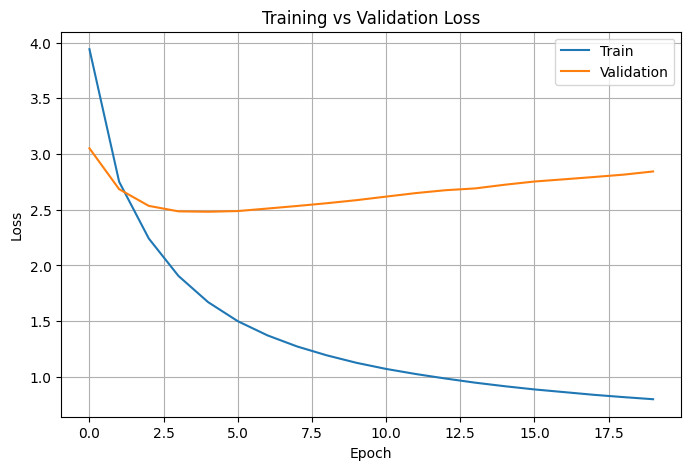

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(history['train'], label='Train')
plt.plot(history['valid'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
itos_trg = vocab_transform[TGT_LANG].get_itos()
special_tokens = {'<pad>', '<sos>', '<eos>'}

def wordpiece_to_text(tokens):
    tokens = [tok for tok in tokens if tok not in special_tokens]
    if not tokens:
        return ''

    if any(tok.startswith('##') for tok in tokens):
        words = []
        current = ''
        for tok in tokens:
            if tok.startswith('##'):
                current += tok[2:]
            else:
                if current:
                    words.append(current)
                current = tok
        if current:
            words.append(current)
        return ' '.join(words)

    joined = ''.join(tok.replace('▁', ' ') for tok in tokens).strip()
    if joined:
        return re.sub(r'\s+', ' ', joined)
    return ' '.join(tokens)

def decode_prediction(indices):
    tokens = [itos_trg[idx] for idx in indices if 0 <= idx < len(itos_trg)]
    return wordpiece_to_text(tokens)

def prepare_src_text(entry):
    if isinstance(entry, str):
        return entry.strip().lower()
    if isinstance(entry, list):
        return ' '.join(entry).strip().lower()
    raise TypeError('Expected string or list of tokens for source sentence.')

def translate_sentence(model, sentence, max_len=100):
    model.eval()
    raw_sentence = prepare_src_text(sentence)

    with torch.no_grad():
        src_tensor = text_transform[SRC_LANG](raw_sentence).unsqueeze(0).to(device)
        src_mask = model.make_src_mask(src_tensor)
        enc_src = model.encoder(src_tensor, src_mask)

        generated = [SOS_IDX]
        for _ in range(max_len):
            trg_tensor = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)
            trg_mask = model.make_trg_mask(trg_tensor)
            output, _ = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            next_token = output[:, -1, :].argmax(dim=-1).item()
            generated.append(next_token)
            if next_token == EOS_IDX:
                break

    translation = decode_prediction(generated[1:])
    return raw_sentence, translation

In [26]:
def preview_translations(split='validation', num_examples=3, max_len=100):
    total = len(dataset[split])
    if total == 0:
        print(f'No samples available in {split} split.')
        return

    count = min(num_examples, total)
    indices = random.sample(range(total), k=count)

    print(f'Previewing {count} example(s) from the {split} split:')
    print('-' * 40)

    for idx in indices:
        src_tokens = dataset[split][idx][SRC_LANG]
        tgt_tokens = dataset[split][idx][TGT_LANG]

        src_text = prepare_src_text(src_tokens)
        reference_text = wordpiece_to_text(tgt_tokens)
        _, predicted_text = translate_sentence(model, src_tokens, max_len=max_len)

        print(f'Example #{idx}')
        print(f'Source     : {src_text}')
        print(f'Reference  : {reference_text}')
        print(f'Prediction : {predicted_text}')
        print('-' * 40)

In [27]:
preview_translations(split='validation', num_examples=3, max_len=60)

Previewing 3 example(s) from the validation split:
----------------------------------------
Example #564
Source     : operation has no operand
Reference  : जडान खोल्न सकेन!
Prediction : [CLS]सञ्चालनसञ्चालनछैन[SEP]
----------------------------------------
Example #800
Source     : not in current directory
Reference  : हालको डाइरेक्टरीमा छैन
Prediction : [CLS] हालको डाइरेक्टरी [SEP]
----------------------------------------
Example #257
Source     : send audio
Reference  : भिडियो पठाउनुहोस्
Prediction : [CLS]अडियोअडियो[SEP]
----------------------------------------


In [28]:
def translate_custom(sentences, max_len=60):
    if isinstance(sentences, str):
        sentences = [sentences]
    for sentence in sentences:
        raw, prediction = translate_sentence(model, sentence, max_len=max_len)
        print('Source     :', raw)
        print('Prediction :', prediction)
        print('-' * 40)


In [38]:
translate_custom([
    "How are you?",
    "Where is the nearest hospital?",
    "Hello nice to meet you!"
], max_len=60)

Source     : how are you?
Prediction : [CLS] तपाईँ साँच्चिकै यी मेट्नुहुन्छ ? [SEP]
----------------------------------------
Source     : where is the nearest hospital?
Prediction : [CLS] जब विण्डोको प्रकार्य छ ? [SEP]
----------------------------------------
Source     : hello nice to meet you!
Prediction : [CLS] तपाईँसँग धेरै पटक मिलाउनुहोस् ! [SEP]
----------------------------------------


### Training Summary

It took 20 full epochs on the multiplicative attention Transformer (lr 1e-4, batch size 64, running on the CPU) to hit a sweet spot: by epoch 5 the validation loss bottomed out at **2.482**, and the final test pass landed at **2.378** (≈10.8 perplexity). That checkpoint now lives at `model/multiplicative_seq2seq_lr1e-4_ep20.pt`, with the freshest vocab snapshot beside it.

And at last we preview the model performance in real case scenario.